In [90]:
import pandas as pd
import os

def read_single_file(year, week):
    """读取单个周数据文件"""
    path = f'idwr_downloads/idwr_{year}_week{week:02d}.csv'
    
    if not os.path.exists(path):
        return None
    
    try:
        t = pd.read_csv(path)
        first_col = t.iloc[:, 0]
        mask = first_col == "Total No."
        total_no_row = mask.idxmax() if mask.any() else 0
        
        data = t.iloc[total_no_row:, [0, 4]].copy()
        data.columns = ['Region', 'RSV_PC']
        data['Week'] = week
        data['Year'] = year
        return data
    
    except Exception as e:
        print(f"Error processing {year} week {week}: {str(e)}")
        return None

def read_all_data(start_year=2015, end_year=2025):
    """读取所有年份和周数的数据并合并"""
    all_data = []
    
    for year in range(start_year, end_year + 1):
        for week in range(1, 54):  # 周数从1到53
            df = read_single_file(year, week)
            if df is not None:
                all_data.append(df)
    
    if not all_data:
        return pd.DataFrame()
    
    combined = pd.concat(all_data, ignore_index=True)
        
    # 转换数据类型
    combined['RSV_PC'] = pd.to_numeric(combined['RSV_PC'], errors='coerce')
    combined['Week'] = combined['Week'].astype(int)
    combined['Year'] = combined['Year'].astype(int)
    
    return combined

# 使用示例
if __name__ == "__main__":
    final_data = read_all_data()
    
    # 保存合并后的数据
    if not final_data.empty:
        final_data.to_csv('combined_rsv_data_2015_2025.csv', index=False)
        print("数据已成功合并并保存为 combined_rsv_data_2015_2025.csv")
        print(f"总记录数: {len(final_data)}")
    else:
        print("没有找到任何有效数据")

数据已成功合并并保存为 combined_rsv_data_2015_2025.csv
总记录数: 26955


In [91]:
import numpy as np

df = pd.read_csv('combined_rsv_data_2015_2025.csv')
df_all = pd.read_csv('../data/japan_surveillance_data.csv')
df_time = df_all[['Year', 'Week', 'date']]
df_time = df_time.drop_duplicates(subset=['Year', 'Week'])
df = df.merge(df_time, on=['Year', 'Week'], how='left')
def calculate_weekly(df):
    # 计算差分得到每周新增
    df['RSV_weekly'] = df.groupby(['Region', 'Year'])['RSV_PC'].diff()
    df['RSV_weekly'] = np.where(
        df.groupby(['Region', 'Year'])['Week'].transform('min') == df['Week'],
        df['RSV_PC'],  # 或者用 np.nan
        df['RSV_weekly']
    )
    return df

# 应用转换
df = df.groupby(['Region'], group_keys=False).apply(calculate_weekly)
df['ILI+'] = df['RSV_weekly']
df = df[df['Region']=='Tokyo']
df = df.sort_values(by=['Year', 'Week'])


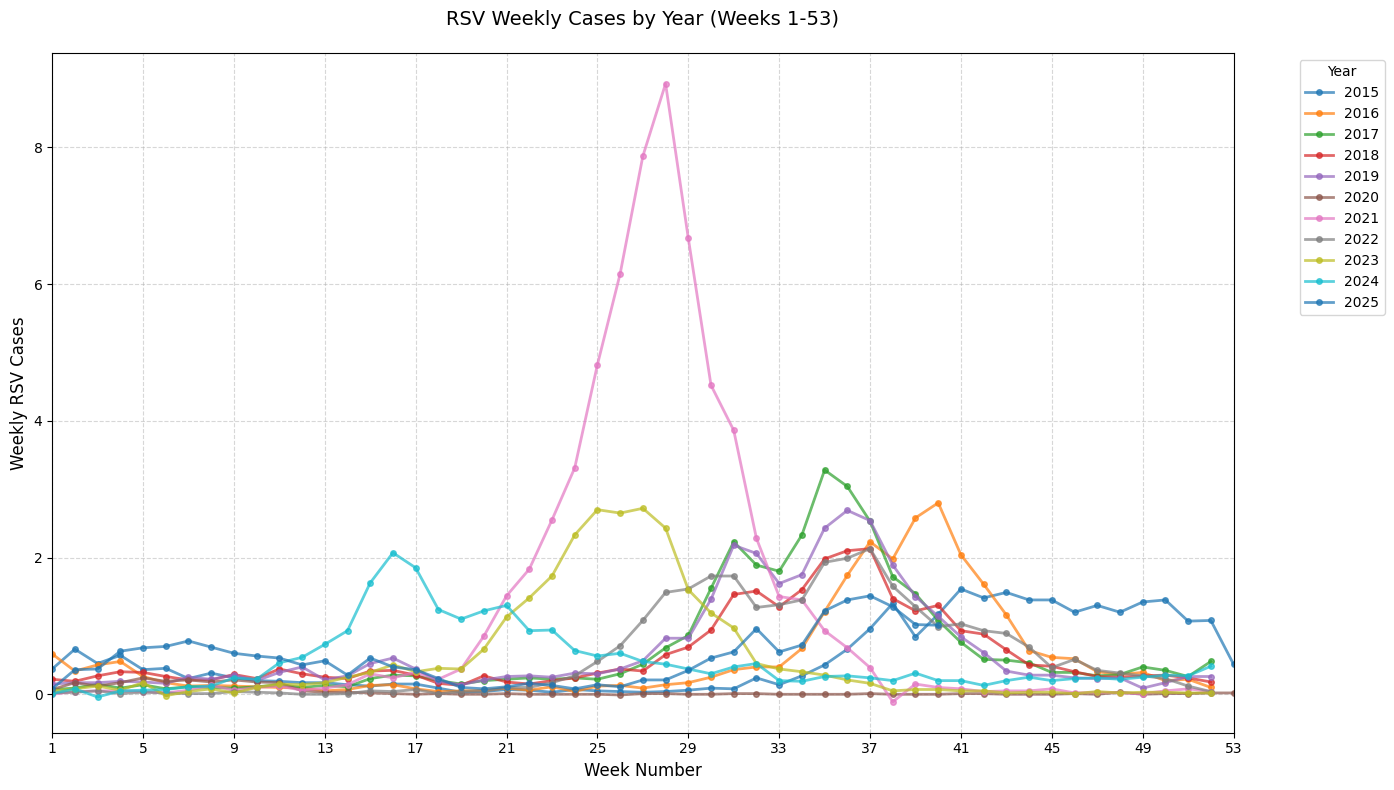

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 确保数据已按年和周排序
df = df.sort_values(['Year', 'Week'])

# 创建图形
plt.figure(figsize=(14, 8))

# 获取唯一的年份列表
years = sorted(df['Year'].unique())

# 为每个年份创建一条线
for year in years:
    year_data = df[df['Year'] == year]
    plt.plot(year_data['Week'], 
             year_data['RSV_weekly'], 
             label=str(year),
             marker='o',
             markersize=4,
             linewidth=2,
             alpha=0.7)

# 美化图形
plt.title('RSV Weekly Cases by Year (Weeks 1-53)', fontsize=14, pad=20)
plt.xlabel('Week Number', fontsize=12)
plt.ylabel('Weekly RSV Cases', fontsize=12)
plt.xticks(np.arange(1, 54, 4))  # 每4周显示一个刻度
plt.xlim(1, 53)

# 添加网格和图例
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

In [93]:
df['holiday_effect'] = 0

# 找出每年8月16日所在的周
for year in df['Year'].unique():
    # 标记这一周为1（盂兰盆节影响周）
    df.loc[(df['Year'] == year) & (df['Week'] == 33), 'holiday_effect'] = 1
df.to_csv('../data/Japan_rsv_data.csv', index=False)
